# XGBoost

In [1]:
import polars as pl
import numpy as np
import xgboost as xgb
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score

In [2]:
data_dir = Path.home() / "teams/b13-domain-2/ca_data/"

X_train = pl.scan_parquet(data_dir / "X_train.parquet")
y_train = pl.scan_parquet(data_dir / "y_train.parquet")

X_test = pl.scan_parquet(data_dir / "X_test.parquet")
y_test = pl.scan_parquet(data_dir / "y_test.parquet")

X_validation = pl.scan_parquet(data_dir / "X_validation.parquet")
y_validation = pl.scan_parquet(data_dir / "y_validation.parquet")

## Training

In [3]:
xgb_clf = xgb.XGBClassifier(device="cuda", verbosity=1)

xgb_clf.fit(X_train, y_train)

/home/gwuwong/.local/lib/python3.11/site-packages/xgboost/data.py:928: UserWarning: Using the default parameters for the polars `LazyFrame.collect`. Consider passing a realized `DataFrame` or `Series` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

## Results

In [3]:
X_train_df = X_train.collect(engine="streaming")
X_test_df = X_test.collect(engine="streaming")
y_train_arr = y_train.collect(engine="streaming").to_numpy().ravel()
y_test_arr = y_test.collect(engine="streaming").to_numpy().ravel()

In [5]:
y_pred = xgb_clf.predict(X_test_df)
y_pred_proba = xgb_clf.predict_proba(X_test_df)[:, 1]

print(f"\nTrain accuracy: {xgb_clf.score(X_train_df, y_train_arr):.4f}")
print(f"Test accuracy: {xgb_clf.score(X_test_df, y_test_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_arr, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_arr, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test_arr, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_test_arr, y_pred_proba):.4f}")


Train accuracy: 0.9993
Test accuracy: 0.9993

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  41980704
           1       0.53      0.22      0.31     28843

    accuracy                           1.00  42009547
   macro avg       0.76      0.61      0.65  42009547
weighted avg       1.00      1.00      1.00  42009547


Confusion Matrix:
[[41975094     5610]
 [   22525     6318]]

ROC-AUC Score: 0.8621

PR-AUC: 0.2272


### Validation

In [12]:
X_validation_df = X_validation.collect(engine="streaming")
y_validation_arr = y_validation.collect(engine="streaming").to_numpy().ravel()

In [7]:
y_pred = xgb_clf.predict(X_validation_df)
y_pred_proba = xgb_clf.predict_proba(X_validation_df)[:, 1]

print(f"\nValidation accuracy: {xgb_clf.score(X_validation_df, y_validation_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_validation_arr, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_validation_arr, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_validation_arr, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_validation_arr, y_pred_proba):.4f}")


Validation accuracy: 0.9993

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  35280437
           1       0.01      0.00      0.00     21703

    accuracy                           1.00  35302140
   macro avg       0.50      0.50      0.50  35302140
weighted avg       1.00      1.00      1.00  35302140


Confusion Matrix:
[[35276015     4422]
 [   21677       26]]

ROC-AUC Score: 0.8512

PR-AUC: 0.0088


### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

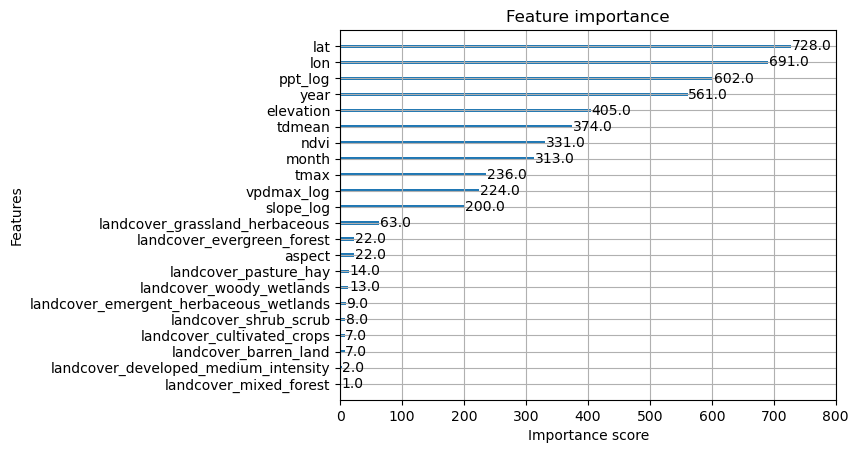

In [8]:
xgb.plot_importance(xgb_clf)

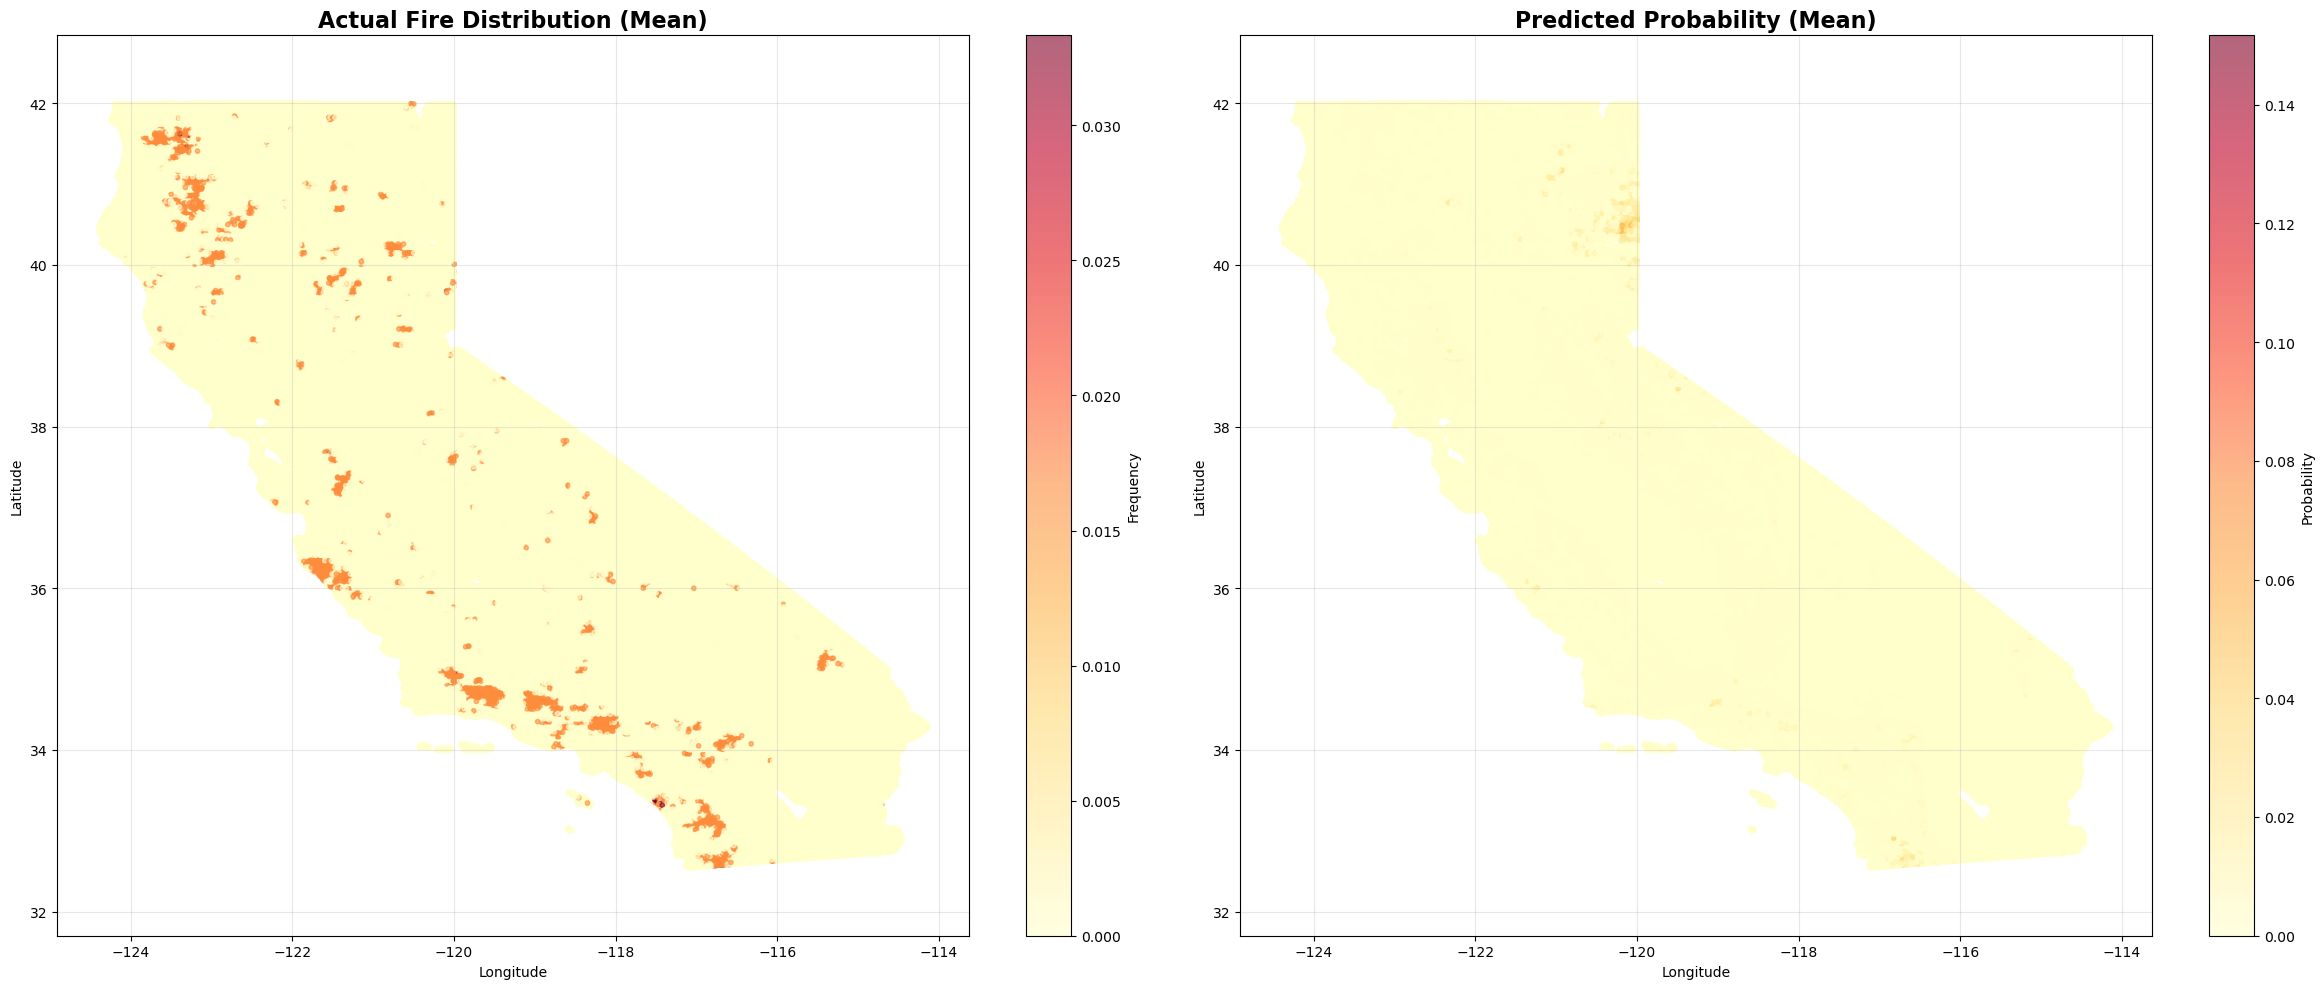

In [9]:
# 1. Prepare data combining coords, actuals, and predictions
# X_validation_df is already a DataFrame from your previous cell
plot_df = X_validation_df.select(['lat', 'lon']).with_columns([
    pl.Series("Actual", y_validation_arr),
    pl.Series("Predicted_Prob", y_pred_proba)
])

# 2. Group by location to get spatial means (handles time dimension if present)
spatial_comp = plot_df.group_by(['lat', 'lon']).agg([
    pl.col("Actual").mean(),
    pl.col("Predicted_Prob").mean()
])

def plot_actual_vs_predict():
    # Since we started with an eager DataFrame (X_validation_df), spatial_comp is also eager.
    # No need to collect.
    data = spatial_comp
    
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # --- Plot 1: Actual ---
    sc1 = axes[0].scatter(
        data['lon'], 
        data['lat'], 
        c=data['Actual'], 
        cmap='YlOrRd',
        s=10, 
        alpha=0.6
    )
    axes[0].set_title("Actual Fire Distribution (Mean)", fontsize=16, fontweight='bold')
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].grid(True, alpha=0.3)
    axes[0].axis('equal')
    plt.colorbar(sc1, ax=axes[0], label="Frequency")
    
    # --- Plot 2: Predicted Probability ---
    sc2 = axes[1].scatter(
        data['lon'], 
        data['lat'], 
        c=data['Predicted_Prob'], 
        cmap='YlOrRd',
        s=10, 
        alpha=0.6,
        # Helper to ensure color scales match if you want them absolute
    )
    axes[1].set_title("Predicted Probability (Mean)", fontsize=16, fontweight='bold')
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")
    axes[1].grid(True, alpha=0.3)
    axes[1].axis('equal')
    plt.colorbar(sc2, ax=axes[1], label="Probability")
    
    plt.tight_layout()
    plt.show()

plot_actual_vs_predict()

Plotting for 2005-10 (Rows: 588369)


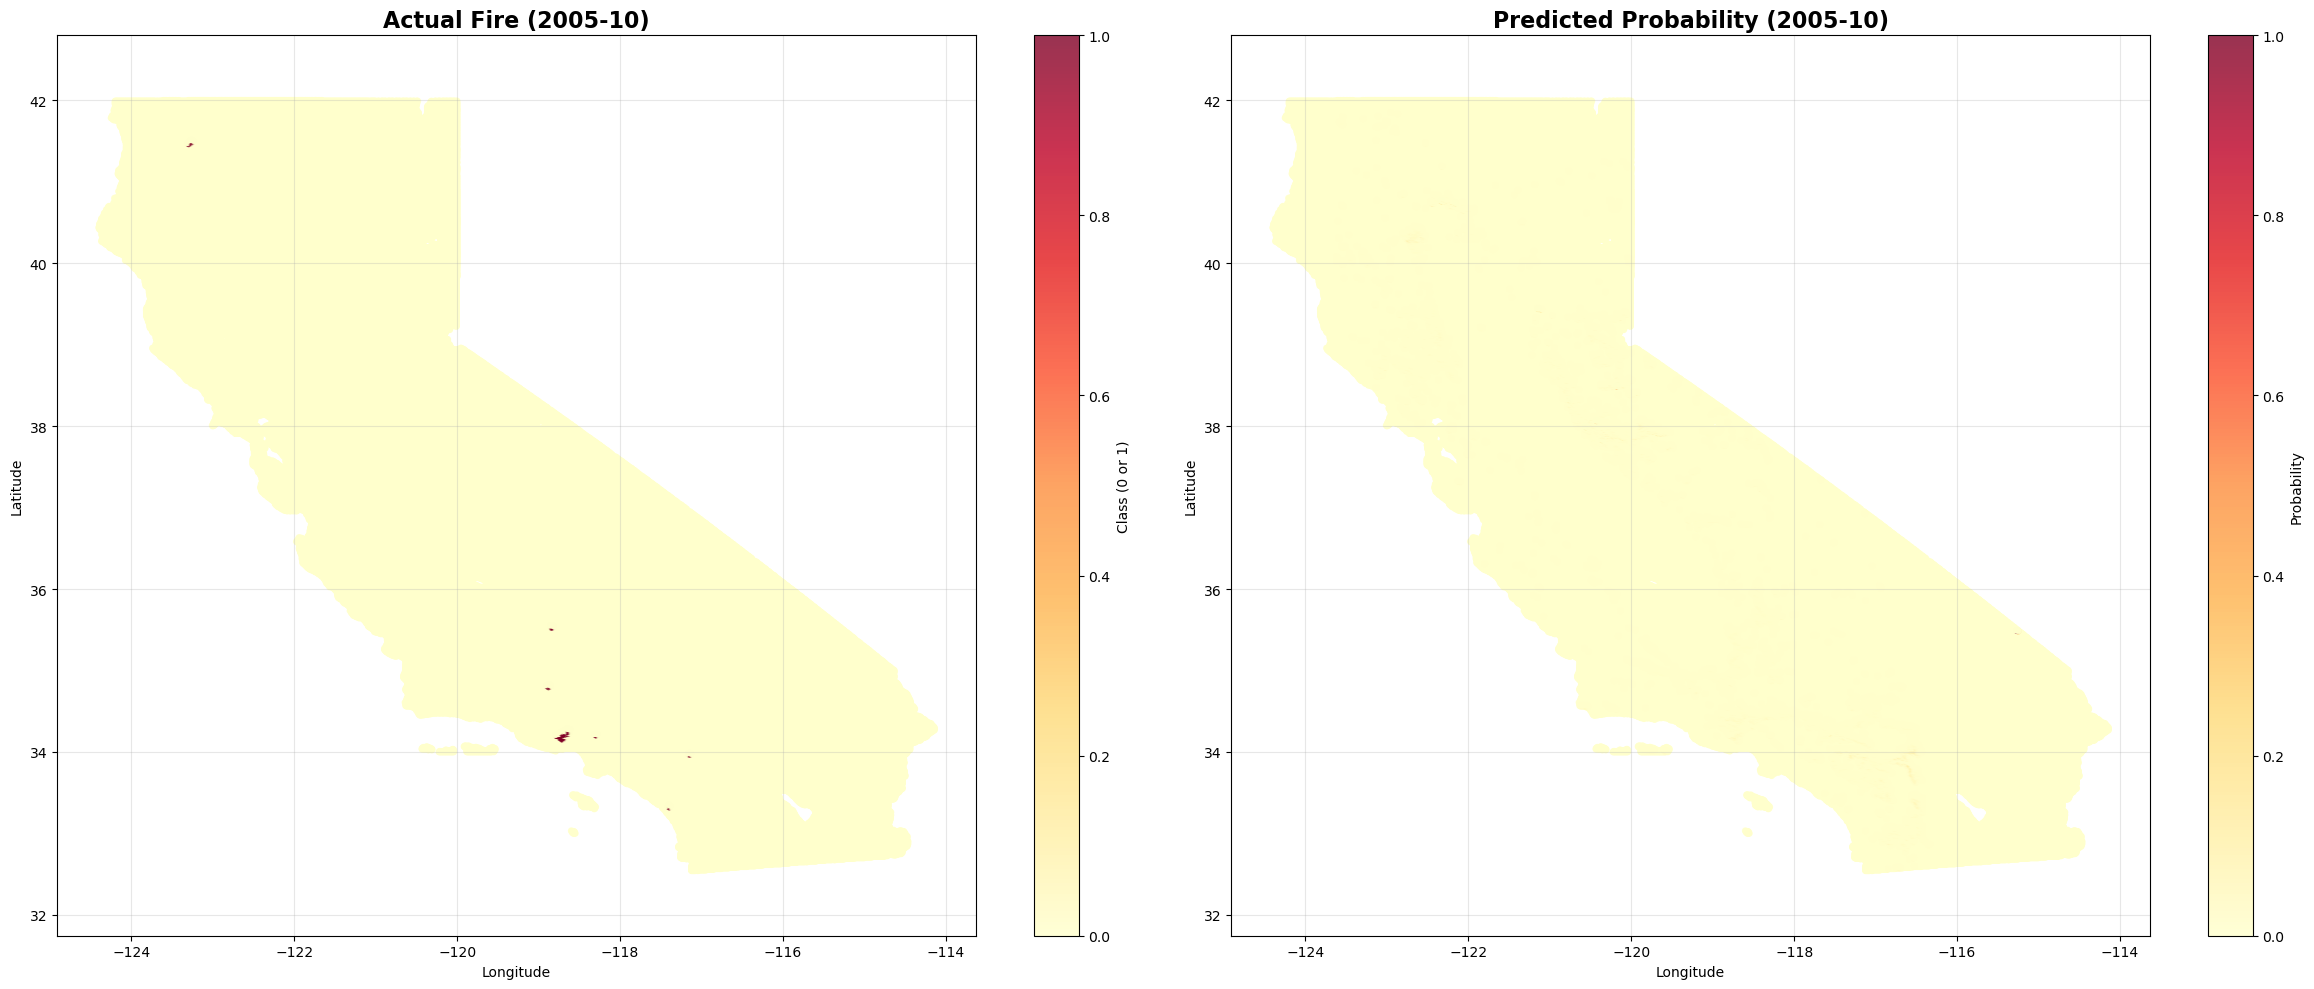

In [10]:
# 1. Prepare data including Year and Month
# Ensure X_validation_df has 'year' and 'month' columns (which it should based on your data)
plot_df = X_validation_df.select(['lat', 'lon', 'year', 'month']).with_columns([
    pl.Series("Actual", y_validation_arr),
    pl.Series("Predicted_Prob", y_pred_proba)
])

def plot_comparison_by_date(target_year, target_month):
    # Filter for the specific year and month
    data = plot_df.filter(
        (pl.col("year") == target_year) & 
        (pl.col("month") == target_month)
    )
    
    if data.height == 0:
        print(f"No data found for {target_year}-{target_month}")
        return

    print(f"Plotting for {target_year}-{target_month} (Rows: {data.height})")

    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # Common settings
    extent = [data['lon'].min(), data['lon'].max(), data['lat'].min(), data['lat'].max()]
    
    # --- Plot 1: Actual ---
    sc1 = axes[0].scatter(
        data['lon'], 
        data['lat'], 
        c=data['Actual'], 
        cmap='YlOrRd',
        s=15, 
        alpha=0.8,
        vmin=0, vmax=1 # Fix scale for binary/probability comparison
    )
    axes[0].set_title(f"Actual Fire ({target_year}-{target_month})", fontsize=16, fontweight='bold')
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].grid(True, alpha=0.3)
    axes[0].axis('equal')
    plt.colorbar(sc1, ax=axes[0], label="Class (0 or 1)")
    
    # --- Plot 2: Predicted Probability ---
    sc2 = axes[1].scatter(
        data['lon'], 
        data['lat'], 
        c=data['Predicted_Prob'], 
        cmap='YlOrRd',
        s=15, 
        alpha=0.8,
        vmin=0, vmax=1 # Fix scale to match Actuals
    )
    axes[1].set_title(f"Predicted Probability ({target_year}-{target_month})", fontsize=16, fontweight='bold')
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")
    axes[1].grid(True, alpha=0.3)
    axes[1].axis('equal')
    plt.colorbar(sc2, ax=axes[1], label="Probability")
    
    plt.tight_layout()
    plt.show()

# Example usage: Change these values to look at different months
plot_comparison_by_date(2005, 10) 

## Hyperparameter Tuning

In [5]:
import optuna

def objective(trial):
    booster = trial.suggest_categorical("booster", ["gbtree", "dart"])

    params = {
        "objective": "binary:logistic",
        "booster": booster,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 5.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 5e-3, 10.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),

        # training
        "tree_method": "hist",
        "max_bin": 64,
        "device": "cuda",
        "verbosity": 0,
        "n_jobs": -1,
    }

    if booster == "dart":
        params.update({
            "sample_type": trial.suggest_categorical("sample_type", ["uniform", "weighted"]),
            "normalize_type": trial.suggest_categorical("normalize_type", ["tree", "forest"]),
            "rate_drop": trial.suggest_float("rate_drop", 1e-4, 0.5, log=True),
            "skip_drop": trial.suggest_float("skip_drop", 1e-4, 0.5, log=True),
        })

    clf_trial = xgb.XGBClassifier(**params)

    clf_trial.fit(X_train_df, y_train_arr)

    y_pred_proba = clf_trial.predict_proba(X_test_df)[:, 1]
    avg_precision = average_precision_score(y_test_arr, y_pred_proba)
    return avg_precision

# Create and run study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
best_params = best_trial.params
print("Best PR-AUC:", best_trial.value)
print("Best params:", best_params)

[I 2026-02-11 02:50:18,596] A new study created in memory with name: no-name-aa318f12-284c-447e-8406-6440ae4cca57
[I 2026-02-11 02:52:13,792] Trial 0 finished with value: 0.25595327391426737 and parameters: {'booster': 'gbtree', 'learning_rate': 0.013330167781748696, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 4.6293355618776494e-08, 'reg_lambda': 0.026218421250464686, 'reg_alpha': 0.010624411531011617, 'subsample': 0.6951081989409497, 'colsample_bytree': 0.8075497862579462}. Best is trial 0 with value: 0.25595327391426737.
[I 2026-02-11 02:54:10,157] Trial 1 finished with value: 0.44879376577083424 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06448689803608328, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 0.005149778987199813, 'reg_lambda': 2.453881390711359, 'reg_alpha': 2.195239837276429, 'subsample': 0.7101538150369355, 'colsample_bytree': 0.977296719524935}. Best is trial 1 with value: 0.44879376577083424.
[I 2026-02-11 02:58:50,784] Trial 2 finished with value:

Number of finished trials:  10
Best trial:
Best PR-AUC: 0.5547726537056231
Best params: {'booster': 'gbtree', 'learning_rate': 0.14559635050338193, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.14593458178192686, 'reg_lambda': 6.105189914454089, 'reg_alpha': 2.2663050626698715, 'subsample': 0.9382830082090757, 'colsample_bytree': 0.8662072305572517}


In [ ]:
# import optuna

# def objective(trial):
#     param = {
#         # "verbosity": 0,
#         "objective": "binary:logistic",
#         "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
#         "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
#         "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#         "n_jobs": -1
#     }

#     if param["booster"] in ["gbtree", "dart"]:
#         # maximum depth of the tree, signifies complexity of the tree.
#         param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
#         # minimum child weight, larger the term more conservative the tree.
#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
#         # defines how selective algorithm is.
#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
#         param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
#         param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
#         param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

#     # Initialize the specific classifier with params
#     clf_trial = xgb.XGBClassifier(device="cuda", verbosity = 1, **param)
    
#     clf_trial.fit(X_train_df, y_train_arr)
    
#     # Predict
#     y_pred_proba = clf_trial.predict_proba(X_test_df)[:, 1]
#     avg_precision = average_precision_score(y_test_arr, y_pred_proba)

#     return avg_precision

# # Create and run study
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# best_trial = study.best_trial
# best_params = best_trial.params
# print("Best PR-AUC:", best_trial.value)
# print("Best params:", best_params)

In [ ]:
from optuna.visualization import plot_intermediate_values
plot_intermediate_values(study)

In [6]:
# best_params = {'booster': 'dart', 'lambda': 9.117568499869883e-08, 'alpha': 0.336665322675411, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.02437131318465964, 'gamma': 0.06501405521706523, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 7.762039131283536e-05, 'skip_drop': 4.5863405380530367e-07}

best_params = {'booster': 'gbtree', 'learning_rate': 0.14559635050338193, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.14593458178192686, 'reg_lambda': 6.105189914454089, 'reg_alpha': 2.2663050626698715, 'subsample': 0.9382830082090757, 'colsample_bytree': 0.8662072305572517}

In [7]:
final_xgb_clf = xgb.XGBClassifier(
    objective = "binary:logistic",
    tree_method = "hist",
    max_bin = 64,
    device = "cuda",
    n_jobs = -1,
    verbosity =1,
    **best_params
)

final_xgb_clf.fit(X_train_df, y_train_arr)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8662072305572517, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.14593458178192686, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14559635050338193,
              max_bin=64, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

In [8]:
final_xgb_clf.save_model('final_xgb_1.ubj')

In [10]:
# y_pred_train = final_xgb_clf.predict(X_train_df)

# print(f"\nTrain accuracy: {accuracy_score(y_pred_train, y_train_arr):.4f}")
# del y_pred_train

y_pred_test = final_xgb_clf.predict(X_test_df)
y_pred_proba_test = final_xgb_clf.predict_proba(X_test_df)[:, 1]

print(f"Test accuracy: {accuracy_score(y_pred_test, y_test_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_arr, y_pred_test))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_arr, y_pred_test))

print(f"\nROC-AUC Score: {roc_auc_score(y_test_arr, y_pred_proba_test):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_test_arr, y_pred_proba_test):.4f}")

Test accuracy: 0.9995

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  41980704
           1       0.78      0.43      0.56     28843

    accuracy                           1.00  42009547
   macro avg       0.89      0.71      0.78  42009547
weighted avg       1.00      1.00      1.00  42009547


Confusion Matrix:
[[41977300     3404]
 [   16452    12391]]

ROC-AUC Score: 0.9448

PR-AUC: 0.5548


In [13]:
y_pred = final_xgb_clf.predict(X_validation_df)
y_pred_proba = final_xgb_clf.predict_proba(X_validation_df)[:, 1]

print(f"\nValidation accuracy: {final_xgb_clf.score(X_validation_df, y_validation_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_validation_arr, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_validation_arr, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_validation_arr, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_validation_arr, y_pred_proba):.4f}")


Validation accuracy: 0.9994

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  35280437
           1       0.11      0.00      0.00     21703

    accuracy                           1.00  35302140
   macro avg       0.55      0.50      0.50  35302140
weighted avg       1.00      1.00      1.00  35302140


Confusion Matrix:
[[35280336      101]
 [   21691       12]]

ROC-AUC Score: 0.8425

PR-AUC: 0.0113


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

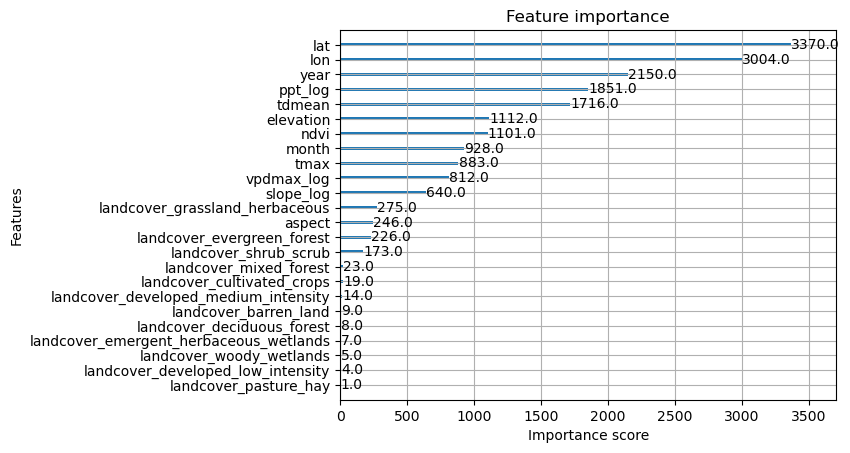

In [14]:
xgb.plot_importance(final_xgb_clf)